# Linear Regression Two ways

1. By Gradient Descent
2. The Analytical Solution  

#### Prerequisites: Calculus, Linear Algebra

In [2]:
# Import depedencies
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**First we make a toy dataset by creating a function that:**
1. Randomly initializes a line 
2. Randomly samples points in the domain
3. Returns an array of the points on the line with added gaussian noise

**Additionally, we make a visualization function that plots the dataset**

In [3]:
def generate_data(size, mean=10.0, std=20.0):
    """Returns a toy linear dataset (x,y)
    """
    # randomly initialize a line
    m, b = np.random.randn(2)
    
    # Generate arrays to be sampled from
    x = np.linspace(1, size, size)
    y = m * x + b
    
    # Add noise to the y output
    noise = np.random.normal(loc=mean, scale=std, size=size)
    sampled_y = y + noise
    
    return x, sampled_y

def show_dataset(x, y, lines=[]):
    """Plots a dataset and an arbitrary number of input lines
    """
    plt.scatter(x, y)
    for line in lines:
        plt.plot(line[0], label=line[1])
    plt.legend()
    plt.show()

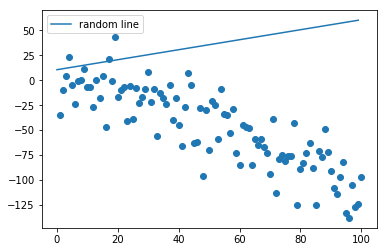

In [4]:
x, y = generate_data(100)
lines = [(0.5*x+10, 'random line')]
show_dataset(x, y, lines)

## Method 1: Gradient Descent

* First lets define a few things: <br>
    1. Equation of a line - This is the method of regression  <br><br>
        $$ \hat{y} = mx + b $$  <br><br>
         
    2. Mean-squared-error Loss function - This is desirable since MSE is convex i.e. it has a global minimum. <br>  
        $$ L = \frac{1}{2N}\sum_{i=1}^{N} (y_i-\hat{y}_i)^2 $$  <br><br>
          
    3. Gradient Descent Rule - This is how the parameters get updated such that the loss is minimized.  <br><br>
        $$ m := m - \alpha \frac{\partial L}{\partial m} $$ <br>
        $$ b := b - \alpha \frac{\partial L}{\partial b} $$ <br><br>

* All we need to do is calculate the gradient of $\hat{y}$ w.r.t. the parameters:  
    1. Derivative with respect to m  <br><br>
        $$ \frac{\partial L}{\partial m} = \frac{\partial L}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial m} = -\frac{1}{N}(y - \hat{y})x $$  <br><br>
    2. Derivative with respect to b  <br><br>
        $$ \frac{\partial L}{\partial b} = \frac{\partial L}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial b} = -\frac{1}{N}(y - \hat{y}) $$ <br><br>

* Now we have the tools to perform linear regression by gradient descent:

In [8]:
def mseloss(value, target):
    """Computes the mean squared error (MSE) loss function
    """
    return 0.5*np.square(target - value).mean()

def gradient_descent(xs, ys, epochs, lr, num_lines=4):
    """Implements gradient descent on a dataset to reduce the MSE loss
    """
    # Initialize the parameters
    m, b = np.random.rand(2)
    
    # Unpack the dataset and begin fitting
    lines = []
    for epoch in range(epochs):
        
        # Iterate over the entire dataset
        for x, y in zip(xs, ys):

            # Calculate the predicted value
            y_hat = m * x + b

            # Calculate the gradients
            del_m = -(1/len(xs))*(y - y_hat)*x
            del_b = -(1/len(xs))*(y - y_hat)

            # Update the parameters
            m -= lr * del_m
            b -= lr * del_b
            
        # Computed the updated predictions
        predictions = m * xs + b
            
        # Add lines to plot
        if epoch % int(epochs / num_lines) == 0:
            lines.append((predictions, f'epoch {epoch}'))
        
        # Compute and print the loss
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} MSE Loss: {mseloss(predictions, ys)}")
        
    #Show the fitted lines
    show_dataset(xs, ys, lines)
    
    return m*xs+b

Epoch: 0 MSE Loss: 3365.8849358763296
Epoch: 100 MSE Loss: 771.2411922059983
Epoch: 200 MSE Loss: 306.11629989934653
Epoch: 300 MSE Loss: 222.74771826612735
Epoch: 400 MSE Loss: 207.80770357615464


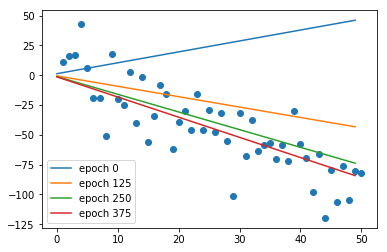

In [11]:
xdata, ydata = generate_data(50)
y_pred = gradient_descent(xdata, ydata, epochs=500, lr=0.00001, num_lines=4)

You can see that gradient descent has successfully fitted the best possible line to dataset, however the loss may still be large since the dataset is very noisy and calculated by the sum of squared distances.

$\newcommand{\x}{X}$
$\newcommand{\t}{\theta}$
$\newcommand{\yh}{\hat{\textbf{y}}}$
$\newcommand{\y}{\textbf{y}}$
## Method 2: Analytical Solution
* This method computes the optimal parameters for the linear model in one-shot. <br>
    1. In general, the linear equation becomes:  <br><br>
$$
\yh = \x\t\qquad\t\in{\Re^{n+1},\quad\x\in{\Re^{m\times(n+1)}}}
$$<br><br>
        - where $\x$ is a matrix of features with 1 appended to the end and $\t$ is a vector of parameters with the bias appended to the end. <br>
        - If you're wondering why the equation for $\yh$ is $\x\t$ and not $\t\x$, it's because we are looking for a vector of paramters that will fit _all_ examples.<br><br>
        
    2. The loss function becomes (check this for yourself):  <br><br>
        $$ L = \frac{1}{2N}(\x\t-\y)^T(\x\t-\y)$$<br><br>
        
* Now we can can go about deriving the analytical solution by solving the following optimization problem: <br><br>
$$ \t^{*} = \underset{\t}{\arg\min} L(\x;\y,\t) $$ 

    1. The first step is to expand the loss function and leave out the constant factor in front for convenience:<br>
    
        $$ L = ((\x\t)^T-\y^T)(\x\t-\y)$$ <br>
        $$ \hspace{0.4cm} = (\x\t)^T(\x\t)-(\x\t)^T\y-\y^T(\x\t)+\y^T\y $$ <br>
        $$ \hspace{0.4cm} = (\x\t)^T(\x\t)-(\x\t)^T\y-((\x\t)^T\y)^T+\y^T\y$$ <br>
        $$ \hspace{0.4cm} = \t^T\x^T\x\t-2\y^T\x\t+\y^T\y $$ <br>
        
    2. Now we use some results of matrix calculus <br><br>
        $$\frac{(\partial{\x\t})}{\partial{\t}} = \x^T, \quad\frac{\partial{\t^TM\t}}{\partial{\t}}=M\t+M^T\t$$ <br>
        <br>
    3. We can now finish the derivation for the optimal $\t$ by taking $\frac{\partial{L}}{\partial{\t}}$ and setting it equal to zero: <br>
        
        $$\frac{\partial{L}}{\partial{\t}}\Bigr\rvert_{\t=\t^{*}} = \x^T\x\t^{*}+\x^T\x\t^{*}-2\x^T\y=0$$<br>
        $$2\x^T\x\t^{*}=2\x^T\y$$<br>
        $$\t^{*}=(\x^T\x)^{-1}\x^T\y \quad_\square$$ <br><br>
    
* Finally, lets write the code to implement this:

In [14]:
# Reshape a copy of x into a matrix with a 1's column appended to it
X = np.c_[xdata[:], np.ones(xdata.shape)].reshape(-1, 2)
print(X[25:50])  # Show a few entries to get the idea

[[26.  1.]
 [27.  1.]
 [28.  1.]
 [29.  1.]
 [30.  1.]
 [31.  1.]
 [32.  1.]
 [33.  1.]
 [34.  1.]
 [35.  1.]
 [36.  1.]
 [37.  1.]
 [38.  1.]
 [39.  1.]
 [40.  1.]
 [41.  1.]
 [42.  1.]
 [43.  1.]
 [44.  1.]
 [45.  1.]
 [46.  1.]
 [47.  1.]
 [48.  1.]
 [49.  1.]
 [50.  1.]]


Analytical solution loss: 194.4691
Gradient descent loss: 205.1399


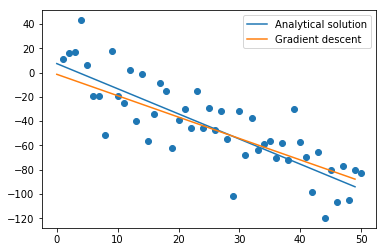

In [15]:
# Finally just apply the equation using numpy! 
# Note: The output will be a [2,1] vector containing m and b
m, b = (np.linalg.inv(X.T@X)@X.T)@ydata

# Looking at the loss compared to the gradient descent method
y_hat = m*xdata + b
closed_form_loss = mseloss(y_hat, ydata)
grad_descent_loss = mseloss(y_pred, ydata)
print("Analytical solution loss: {0:.4f}\nGradient descent loss: {1:.4f}".format(
    closed_form_loss, grad_descent_loss
))
line = [(y_hat, "Analytical solution"), (y_pred, "Gradient descent")]
show_dataset(xdata, ydata, line)

Even after 500 iterations over the whole data set, gradient descent still does not do as well as the analytical solution!